<a href="https://colab.research.google.com/github/sawesky/Spam-Classification/blob/main/EmailSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [30]:
!kaggle datasets download wanderfj/enron-spam/

 69% 20.0M/28.8M [00:00<00:00, 94.6MB/s]
100% 28.8M/28.8M [00:00<00:00, 110MB/s] 


In [ ]:
!unzip enron-spam.zip

In [32]:
!pip install pandas

In [96]:
from IPython.display import display, HTML
from IPython.display import display

CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [163]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import sklearn as sk
import os
import re
import string
import itertools
import collections
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
for (root, dirs, files) in os.walk('enron1', topdown = 'True'):
  print(root)
  print(dirs)
  print(files)
  print('-------------')

In [36]:
enrlist = ['enron1', 'enron2', 'enron3', 'enron4', 'enron5', 'enron6']
all_ham, all_spam = [], []

for dataset in enrlist:

  pathwalk = os.walk(dataset)
  for root, dr, file in pathwalk:
    if 'ham' in str(file):
      for obj in file:
        with open(root + '/' + obj, encoding = 'latin1') as ip:
          all_ham.append(" ".join(ip.readlines()))
    elif 'spam' in str(file):
      for obj in file:
        with open(root + '/' + obj, encoding = 'latin1') as ip:
          all_spam.append(" ".join(ip.readlines()))


In [37]:
all_ham = list(set(all_ham))
all_spam = list(set(all_spam))
all_data = all_ham + all_spam
labels = ["ham"]*len(all_ham) + ["spam"]*len(all_spam)
raw_df = pd.DataFrame({"email": all_data, "label": labels})
raw_df.info()
raw_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30493 entries, 0 to 30492
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   30493 non-null  object
 1   label   30493 non-null  object
dtypes: object(2)
memory usage: 476.6+ KB


,email,label
0,Subject: re : fw : enron center north / enron ...,ham
1,"Subject: re :\n you ' re done !\n regards ,\n ...",ham
2,Subject: issues with measurement ( gary anders...,ham
3,Subject: re : a note being sent out under john...,ham
4,Subject: hpl / conoco - teco waha 03 / 23 / 01...,ham
...,...,...
30488,Subject: don ' t be a fuddy - duddy . . . use ...,spam
30489,Subject: feel insecure about your penis size ?...,spam
30490,Subject: re : pretty boy wants to meet a real ...,spam
30491,"Subject: accept plnnacle system , corel , alla...",spam


*preprocessing*

In [44]:
def lowercase(s):
  return s.lower()

def remove_punctuation(s):
  without_punc = "".join([char for char in s if char not in string.punctuation])
  return without_punc

def remove_specials_and_tokenize(s):
  s = re.sub(r'http[s]?://\S+', '', s)
  tokens = re.split(r'[\W_]|\d+', s)
  tokens = [token for token in tokens if token][1:]
  return tokens

stoplist = set(stopwords.words('english') + ['enron', 'ect', 'hou', 'e', 'http'])
def remove_stopwords(tokens):
  res = [word for word in tokens if word not in stoplist]
  return res

stemmer = PorterStemmer()
def word_stemmer(tokens):
  res = [stemmer.stem(token) for token in tokens]
  return " ".join(res)

lemmatizer = WordNetLemmatizer()
def word_lemmatizer(tokens):
  res = [lemmatizer.lemmatize(token) for token in tokens]
  return " ".join(res)


def clean_frame(s):
  res = lowercase(s)
  res = remove_punctuation(res)
  tokens = remove_specials_and_tokenize(res)
  tokens = remove_stopwords(tokens)
  out_string = word_lemmatizer(tokens)
  return out_string


In [45]:
raw_df["preprocessed"] = raw_df["email"].apply(lambda in_str: clean_frame(in_str))
raw_df.head()

,email,label,preprocessed,prepd_tokens
0,Subject: re : fw : enron center north / enron ...,ham,fw center north center south damage restoratio...,"[fw, center, north, center, south, damage, res..."
1,"Subject: re :\n you ' re done !\n regards ,\n ...",ham,done regard jeff original message lavorato joh...,"[done, regard, jeff, original, message, lavora..."
2,Subject: issues with measurement ( gary anders...,ham,issue measurement gary anderson group seems se...,"[issue, measurement, gary, anderson, group, se..."
3,Subject: re : a note being sent out under john...,ham,note sent john sherriff name thought cover not...,"[note, sent, john, sherriff, name, thought, co..."
4,Subject: hpl / conoco - teco waha 03 / 23 / 01...,ham,hpl conoco teco waha purchase daren conoco inv...,"[hpl, conoco, teco, waha, purchase, daren, con..."


In [61]:
raw_df["prepd_tokens"] = raw_df["preprocessed"].apply(lambda s: s.split())
raw_df = raw_df[raw_df.preprocessed.str.len() != 0]
raw_df.head()

,email,label,preprocessed,prepd_tokens
0,Subject: re : fw : enron center north / enron ...,ham,fw center north center south damage restoratio...,"[fw, center, north, center, south, damage, res..."
1,"Subject: re :\n you ' re done !\n regards ,\n ...",ham,done regard jeff original message lavorato joh...,"[done, regard, jeff, original, message, lavora..."
2,Subject: issues with measurement ( gary anders...,ham,issue measurement gary anderson group seems se...,"[issue, measurement, gary, anderson, group, se..."
3,Subject: re : a note being sent out under john...,ham,note sent john sherriff name thought cover not...,"[note, sent, john, sherriff, name, thought, co..."
4,Subject: hpl / conoco - teco waha 03 / 23 / 01...,ham,hpl conoco teco waha purchase daren conoco inv...,"[hpl, conoco, teco, waha, purchase, daren, con..."


In [62]:
tokens_df = pd.DataFrame()
tokens_df = raw_df[["prepd_tokens", "label"]].copy()
tokens_df.head()

mails_df = pd.DataFrame()
mails_df = raw_df[["preprocessed", "label"]].copy()
mails_df.head()
mails_df.to_csv('./emails_cleaned.csv', index=False)

EDA

In [63]:
grouped = tokens_df.groupby(["label"])
tokens_ham = grouped.get_group("ham")
tokens_spam = grouped.get_group("spam")

grouped = mails_df.groupby(["label"])
mails_ham = grouped.get_group("ham")
mails_spam = grouped.get_group("spam")

In [110]:
all_email_length = mails_df.preprocessed.str.len()
all_email_word_count = tokens_df.prepd_tokens.apply(len)
raw_df["email_length"] = all_email_length
raw_df["email_word_count"] = all_email_word_count
raw_df.head()

<ipython-input-110-30d8f5c08c47>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["email_length"] = all_email_length
<ipython-input-110-30d8f5c08c47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df["email_word_count"] = all_email_word_count


,email,label,preprocessed,prepd_tokens,email_length,email_word_count
0,Subject: re : fw : enron center north / enron ...,ham,fw center north center south damage restoratio...,"[fw, center, north, center, south, damage, res...",4679,680
1,"Subject: re :\n you ' re done !\n regards ,\n ...",ham,done regard jeff original message lavorato joh...,"[done, regard, jeff, original, message, lavora...",217,34
2,Subject: issues with measurement ( gary anders...,ham,issue measurement gary anderson group seems se...,"[issue, measurement, gary, anderson, group, se...",493,70
3,Subject: re : a note being sent out under john...,ham,note sent john sherriff name thought cover not...,"[note, sent, john, sherriff, name, thought, co...",1608,237
4,Subject: hpl / conoco - teco waha 03 / 23 / 01...,ham,hpl conoco teco waha purchase daren conoco inv...,"[hpl, conoco, teco, waha, purchase, daren, con...",103,17


In [ ]:
email_length = mails_spam.preprocessed.str.len()
email_word_count = tokens_spam.prepd_tokens.apply(len)
mean_length = email_length.mean()
std_length = email_length.std()
mean_count = email_word_count.mean()
std_count = email_word_count.std()
display(email_length.describe())
display(email_word_count.describe())

Q1 = email_length.quantile(0.25)
Q3 = email_length.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

sns.set(style="whitegrid")
plt.figure(figsize = (10, 6))
filtered_email_length = email_length[(email_length >= lower_bound) & (email_length <= upper_bound)]
sns.histplot(filtered_email_length, kde = True, bins = 30)
plt.title('Email length')

Q1 = email_word_count.quantile(0.25)
Q3 = email_word_count.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
filtered_email_word_count = email_word_count[(email_word_count >= lower_bound) & (email_word_count <= upper_bound)]
sns.histplot(filtered_email_word_count, kde = True, bins = 30)
plt.title('Word count')

In [53]:
ham_token_extract = list(itertools.chain(*tokens_ham["prepd_tokens"]))
ham_token_count = collections.Counter(ham_token_extract)
most_occ_ham_tokens = pd.DataFrame(ham_token_count.most_common(15), columns=['words', 'count'])
display(most_occ_ham_tokens)

spam_token_extract = list(itertools.chain(*tokens_spam["prepd_tokens"]))
spam_token_count = collections.Counter(spam_token_extract)
most_occ_spam_tokens = pd.DataFrame(spam_token_count.most_common(15), columns=['words', 'count'])
display(most_occ_spam_tokens)

,words,count
0,please,12510
1,com,12031
2,company,11938
3,subject,11814
4,would,11705
5,pm,9169
6,cc,9112
7,said,8926
8,energy,8881
9,deal,8659


,words,count
0,company,11847
1,com,9863
2,u,7920
3,email,7233
4,information,6542
5,price,6256
6,please,6231
7,statement,6028
8,security,5464
9,may,5297


wordclouds

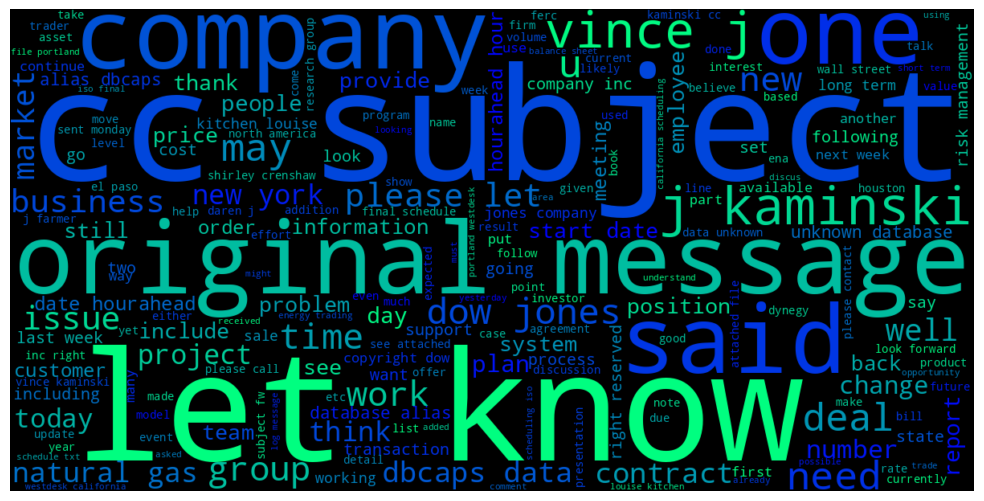

In [105]:
str_token = ' '.join(map(str, ham_token_extract)) # Convert list token to string
wordcloud_type1 = WordCloud(width = 1200, height = 600, colormap = "winter", relative_scaling=1).generate(str_token)
fig = plt.figure(figsize=(10, 6), tight_layout=True)
plt.imshow(wordcloud_type1, interpolation='bilinear')
plt.axis("off")
plt.show()

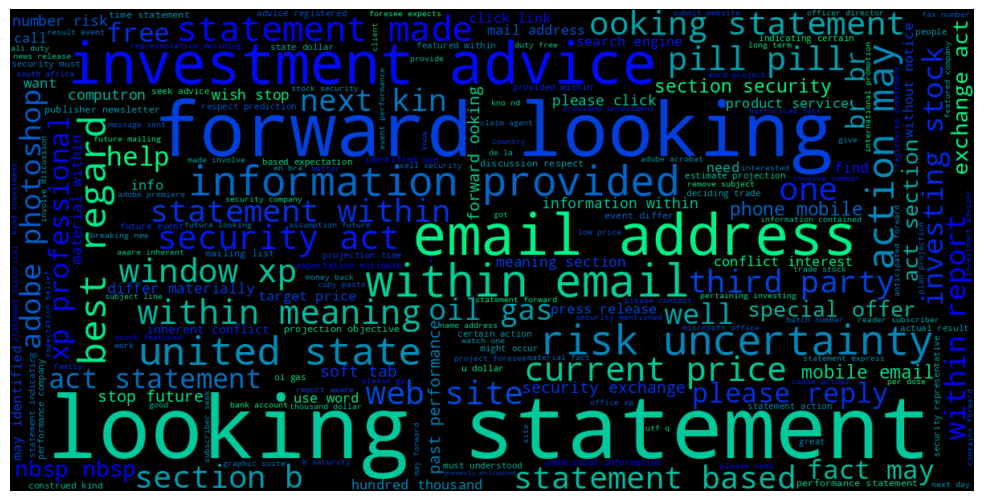

In [106]:
str_token = ' '.join(map(str, spam_token_extract)) # Convert list token to string
wordcloud_type1 = WordCloud(width = 1200, height = 600, colormap = "winter", relative_scaling=1).generate(str_token)
fig = plt.figure(figsize=(10, 6), tight_layout=True)
plt.imshow(wordcloud_type1, interpolation='bilinear')
plt.axis("off")
plt.show()

feat extraction

In [118]:
data = raw_df.copy()
data['label'] = data['label'].map({'spam': 1, 'ham': 0})
data.head()

,email,label,preprocessed,prepd_tokens,email_length,email_word_count
0,Subject: re : fw : enron center north / enron ...,0,fw center north center south damage restoratio...,"[fw, center, north, center, south, damage, res...",4679,680
1,"Subject: re :\n you ' re done !\n regards ,\n ...",0,done regard jeff original message lavorato joh...,"[done, regard, jeff, original, message, lavora...",217,34
2,Subject: issues with measurement ( gary anders...,0,issue measurement gary anderson group seems se...,"[issue, measurement, gary, anderson, group, se...",493,70
3,Subject: re : a note being sent out under john...,0,note sent john sherriff name thought cover not...,"[note, sent, john, sherriff, name, thought, co...",1608,237
4,Subject: hpl / conoco - teco waha 03 / 23 / 01...,0,hpl conoco teco waha purchase daren conoco inv...,"[hpl, conoco, teco, waha, purchase, daren, con...",103,17


In [154]:
X_train, X_test, y_train, y_test = train_test_split(data["preprocessed"], data["label"], train_size = 0.7, random_state = 42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [162]:
vectorizer = TfidfVectorizer()
vectors_train = vectorizer.fit_transform(X_train)
display(vectors_train.shape)
vectors_test = vectorizer.transform(X_test)
display(vectors_test.shape)


(21337, 113244)

(9145, 113244)

naivni bejs



In [164]:
nb_clf = MultinomialNB(alpha=0.2)
nb_clf.fit(vectors_train, y_train)
y_pred_nb = nb_clf.predict(vectors_test)
print(classification_report(y_test,y_pred_nb))
print("Accuracy score: {}".format(round(accuracy_score(y_test,y_pred_nb),5)))
k1=round(accuracy_score(y_test,y_pred_nb),5)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4838
           1       0.99      0.98      0.99      4307

    accuracy                           0.99      9145
   macro avg       0.99      0.99      0.99      9145
weighted avg       0.99      0.99      0.99      9145

Accuracy score: 0.98611


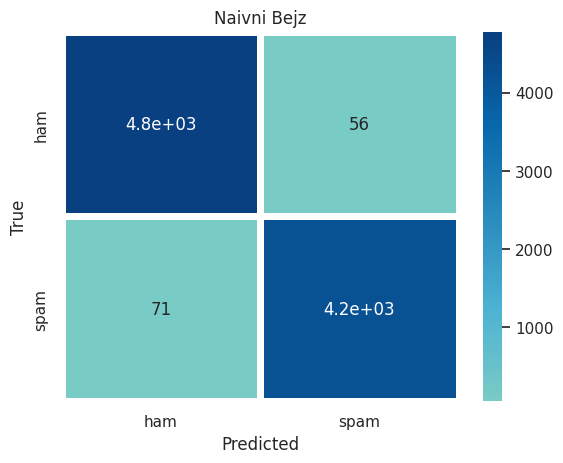

In [166]:
conf_mat = confusion_matrix(y_test, y_pred_nb)

ax=plt.subplot()

sns.heatmap(conf_mat, annot=True, ax=ax, linewidths=5, cmap="GnBu", center=0)

ax.set_xlabel('Predicted');ax.set_ylabel('True')

ax.set_title('Naivni Bejz')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()

svm

In [169]:
svm_clf = SVC(kernel = 'rbf', gamma = 1.0)
svm_clf.fit(vectors_train, y_train)
y_pred_svm = svm_clf.predict(vectors_test)
print(classification_report(y_test,y_pred_svm))
print("Accuracy score: {}".format(round(accuracy_score(y_test,y_pred_svm),5)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      4838
           1       0.98      0.99      0.99      4307

    accuracy                           0.99      9145
   macro avg       0.99      0.99      0.99      9145
weighted avg       0.99      0.99      0.99      9145

Accuracy score: 0.98633


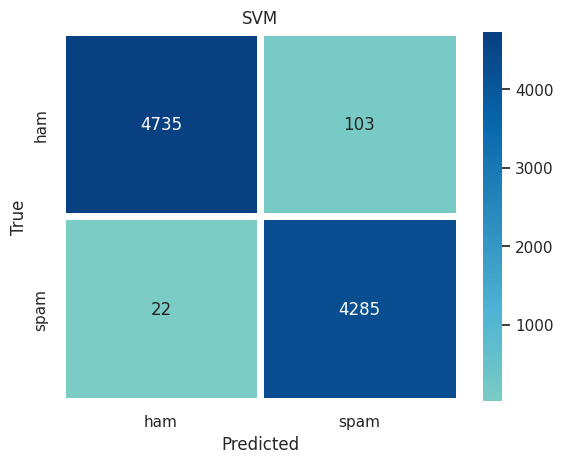

In [172]:
conf_mat = confusion_matrix(y_test, y_pred_svm)

ax=plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax, linewidths=5, cmap="GnBu", center=0)

ax.set_xlabel('Predicted');ax.set_ylabel('True')

ax.set_title('SVM')
ax.xaxis.set_ticklabels(['ham','spam'])
ax.yaxis.set_ticklabels(['ham','spam'])
plt.show()